In [153]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

In [154]:
# Load data
df = pd.read_csv('../data/all_queries.csv')

In [155]:
df.head()

,date,time,tweet,tweet_id,hashtags,user_id,username,location,num_followers,geo_enabled,long,lat,relevant,neg_sent_score,neu_sent_score,pos_sent_score,compound_sent_score,sent_class
0,11/8/21,17:11:01,Defender Radio Live: Canid Response Teams and ...,1.457760e+18,[],9.202440e+08,CoyoteWatchCAN,"Ontario, CA",4420.0,True,NaN,NaN,1.0,0.000,0.912,0.088,0.2023,positive
1,11/8/21,14:25:52,Yaw 💃💃. Good Morning Twitter Family 🤩✨,1.457720e+18,[],1.456960e+18,coyote_kissa1,"Pasadena, CA",57.0,False,NaN,NaN,1.0,0.000,0.634,0.366,0.6369,positive
2,11/8/21,12:27:50,"At this moment, I have a neighbor that lives 7...",1.457690e+18,[],1.326530e+18,DavidCMaybury,"Perris, CA",438.0,True,NaN,NaN,1.0,0.000,0.930,0.070,0.5719,positive
3,11/8/21,10:51:07,@AstroBackyard Had the coyotes barking within ...,1.457660e+18,[],6.883438e+07,darrenreely,"Los Angeles, CA",147.0,True,NaN,NaN,0.0,0.039,0.912,0.049,0.1511,positive
4,11/8/21,8:28:38,really just saw a coyote cross the street and ...,1.457630e+18,[],2.323440e+09,angeIiques,she/her,109.0,True,NaN,NaN,1.0,0.256,0.744,0.000,-0.8519,negative


Looks like saving the queries to csv reduced the accuracy of `tweet_id` and `user_id`. This might be a problem in the future and when I join future queries to this main csv. In the time being, I will join on `tweet`.

In [156]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539 entries, 0 to 538
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date                 538 non-null    object 
 1   time                 538 non-null    object 
 2   tweet                538 non-null    object 
 3   tweet_id             538 non-null    float64
 4   hashtags             538 non-null    object 
 5   user_id              538 non-null    float64
 6   username             538 non-null    object 
 7   location             529 non-null    object 
 8   num_followers        538 non-null    float64
 9   geo_enabled          538 non-null    object 
 10  long                 9 non-null      float64
 11  lat                  9 non-null      float64
 12  relevant             538 non-null    float64
 13  neg_sent_score       538 non-null    float64
 14  neu_sent_score       538 non-null    float64
 15  pos_sent_score       538 non-null    flo

# Exploring tweets that are not relevant

In [157]:
df_nr = df[df['relevant'] == 0].copy()

In [158]:
df_nr.shape

(422, 18)

## Look at the tweets

In [159]:
ir_tweets = df_nr['tweet']
ir_tweets[:5]

3     @AstroBackyard Had the coyotes barking within ...
6                         @shenjonsin but the coyotes !
7      To make it worse no one else saw the coyote bruh
9     Wile E Coyote was a victim. The Road Runner is...
11    @WhatSayU_2020 @DineshDSouza Some children wer...
Name: tweet, dtype: object

### Lets look at the most common words

In [160]:
from text_normalizer import tweet_preprocessor

In [161]:
norm_tweets = [tweet_preprocessor(tweet) for tweet in ir_tweets]
len(norm_tweets)

422

In [162]:
from collections import Counter
from sklearn.feature_extraction import _stop_words

In [163]:
stop_words = _stop_words.ENGLISH_STOP_WORDS

In [164]:
# Get all the words into one list, lowercase them, and remove stopwords
def filter_tweets(tweets: list) -> list:
    all_words = ' '.join(tweets).split(' ')
    all_words = [w.lower() for w in all_words]
    all_words = [w for w in all_words if w not in stop_words]
    all_words = [w for w in all_words if w not in ['coyotes', 'coyote', 'amp']]  # amp is for ampersand
    return all_words

In [165]:
words = filter_tweets(norm_tweets)

In [166]:
word_count = Counter(words)

In [167]:
# Most common 20 words from irrelevant tweets
common_words = word_count.most_common(20)
common_words

[('like', 45),
 ('ducks', 27),
 ('school', 23),
 ('game', 23),
 ('nhl', 22),
 ('win', 18),
 ('better', 17),
 ('high', 17),
 ('tonight', 15),
 ('come', 15),
 ('got', 14),
 ('hey', 14),
 ('arizona', 13),
 ('night', 13),
 ('springs', 13),
 ('week', 13),
 ('make', 12),
 ('new', 12),
 ('history', 12),
 ('indian', 12)]

### Visualize most common 20 words from irrelevant tweets

In [168]:
irrel_words = []
irrel_counts = []
for current_word, current_count in common_words:
    irrel_words.append(current_word)
    irrel_counts.append(current_count)

irrel_words.reverse()
irrel_counts.reverse()

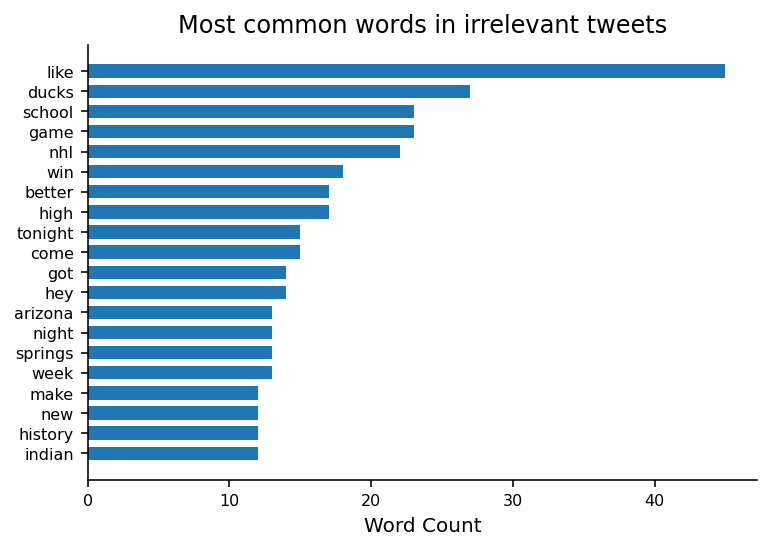

In [180]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.barh(irrel_words, irrel_counts, height=.66)
ax.set_title('Most common words in irrelevant tweets')
ax.set_xlabel('Word Count')
ax.tick_params(axis='both', labelsize=8)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

Based on this plot there are some words we might want to exclude from our twitter api query. These include:
- ducks
- school
- game
- nhl
- win
- arizona
- indian

However, some of these words might be in relevant tweets. Lets take a look at the most common words in relevant tweets.

# Exploring tweets that are relevant

In [170]:
df_rel = df[df['relevant'] == 1].copy()
df_rel.head()

,date,time,tweet,tweet_id,hashtags,user_id,username,location,num_followers,geo_enabled,long,lat,relevant,neg_sent_score,neu_sent_score,pos_sent_score,compound_sent_score,sent_class
0,11/8/21,17:11:01,Defender Radio Live: Canid Response Teams and ...,1.457760e+18,[],9.202440e+08,CoyoteWatchCAN,"Ontario, CA",4420.0,True,NaN,NaN,1.0,0.000,0.912,0.088,0.2023,positive
1,11/8/21,14:25:52,Yaw 💃💃. Good Morning Twitter Family 🤩✨,1.457720e+18,[],1.456960e+18,coyote_kissa1,"Pasadena, CA",57.0,False,NaN,NaN,1.0,0.000,0.634,0.366,0.6369,positive
2,11/8/21,12:27:50,"At this moment, I have a neighbor that lives 7...",1.457690e+18,[],1.326530e+18,DavidCMaybury,"Perris, CA",438.0,True,NaN,NaN,1.0,0.000,0.930,0.070,0.5719,positive
4,11/8/21,8:28:38,really just saw a coyote cross the street and ...,1.457630e+18,[],2.323440e+09,angeIiques,she/her,109.0,True,NaN,NaN,1.0,0.256,0.744,0.000,-0.8519,negative
5,11/8/21,7:13:42,my dog just scared tf out of a coyote then cha...,1.457610e+18,[],2.936604e+09,_danimaee,"calabasas, ca",3446.0,True,NaN,NaN,1.0,0.142,0.782,0.076,-0.4215,negative


In [171]:
df_rel.shape

(116, 18)

In [172]:
rel_tweets = df_rel['tweet']
rel_tweets[:5]

0    Defender Radio Live: Canid Response Teams and ...
1               Yaw 💃💃. Good Morning Twitter Family 🤩✨
2    At this moment, I have a neighbor that lives 7...
4    really just saw a coyote cross the street and ...
5    my dog just scared tf out of a coyote then cha...
Name: tweet, dtype: object

In [173]:
norm_rel_tweets = [tweet_preprocessor(tweet) for tweet in rel_tweets]
rel_words = filter_tweets(norm_rel_tweets)
rel_words[:5]

['defender', 'radio', 'live', 'canid', 'response']

In [174]:
rel_word_count = Counter(rel_words)
common_rel_words = rel_word_count.most_common(20)
common_rel_words

[('just', 24),
 ('dog', 19),
 ('outside', 13),
 ('like', 13),
 ('away', 11),
 ('let', 11),
 ('morning', 10),
 ('night', 10),
 ('cat', 10),
 ('seen', 10),
 ('know', 9),
 ('saw', 9),
 ('day', 9),
 ('deer', 8),
 ('neighborhood', 8),
 ('street', 7),
 ('car', 7),
 ('cats', 7),
 ('got', 7),
 ('walk', 7)]

In [175]:
rel_words = []
rel_counts = []
for current_word, current_count in common_rel_words:
    rel_words.append(current_word)
    rel_counts.append(current_count)

rel_words.reverse()
rel_counts.reverse()

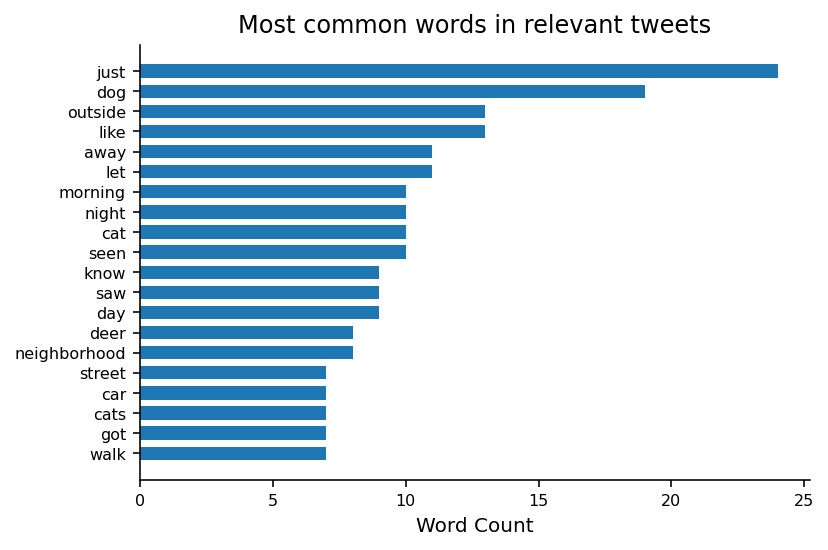

In [176]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.barh(rel_words, rel_counts, height=.66)
ax.set_title('Most common words in relevant tweets')
ax.set_xlabel('Word Count')
ax.tick_params(axis='both', labelsize=8)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

Lets look at words that are in both the most common relevant and irrelevant tweets

In [177]:
rel_words_set = set(rel_words)
irrel_words_set = set(irrel_words)
words_in_both = rel_words_set.intersection(irrel_words_set)
words_in_both

{'got', 'like', 'night'}

Lets look at the most common words that are only in the irrelevant tweets

In [178]:
only_irrel_words = irrel_words_set - rel_words_set
print(only_irrel_words)

{'new', 'springs', 'better', 'make', 'indian', 'tonight', 'hey', 'history', 'ducks', 'game', 'arizona', 'school', 'high', 'week', 'come', 'win', 'nhl'}


Might be a good idea to remove some of these words. Probably would want to remove the nouns:
- indian
- ducks
- game
- arizona
- school
- nhl
- win (even though its not a noun im assuming its sports related)

### Visualize relevant and irrelevant common words together

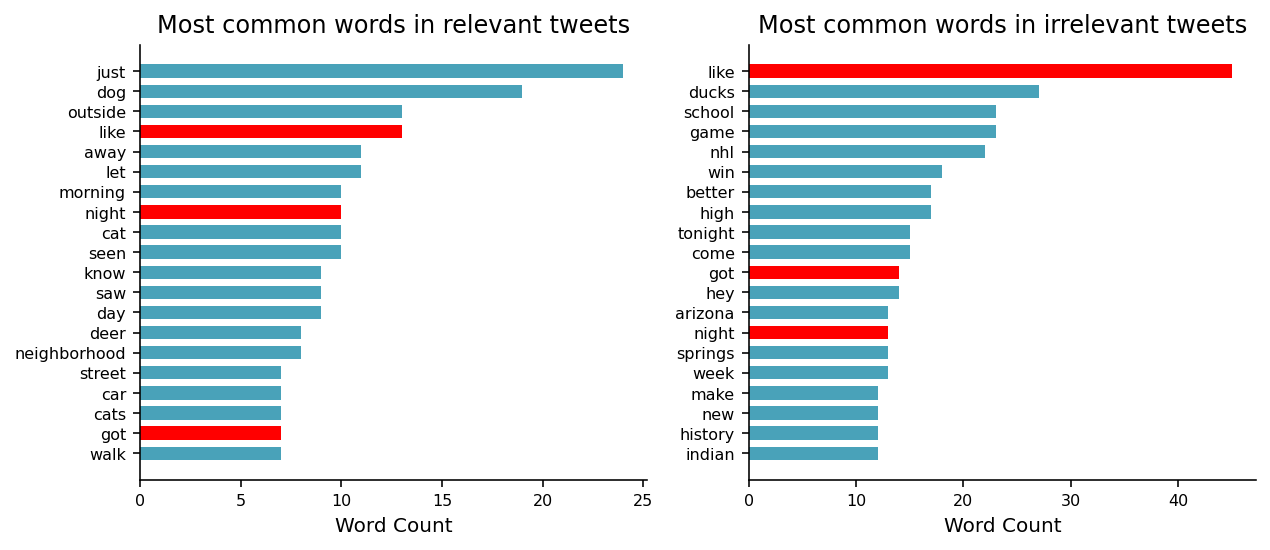

In [185]:
fig, axes = plt.subplots(ncols=2,figsize=(10, 4))
DEFAULT_COLOR = '#49a2b9'
MATCHING_COLOR = 'red'

# Relevant tweets

rel_colors = []
for word in rel_words:
    if word in words_in_both:
        rel_colors.append(MATCHING_COLOR)
    else:
        rel_colors.append(DEFAULT_COLOR)

axes[0].barh(rel_words, rel_counts, height=.66, color=rel_colors)
axes[0].set_title('Most common words in relevant tweets')
axes[0].set_xlabel('Word Count')
axes[0].tick_params(axis='both', labelsize=8)

axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)

# Irrelevant tweets

irrel_colors = []
for word in irrel_words:
    if word in words_in_both:
        irrel_colors.append(MATCHING_COLOR)
    else:
        irrel_colors.append(DEFAULT_COLOR)

axes[1].barh(irrel_words, irrel_counts, height=.66, color=irrel_colors)
axes[1].set_title('Most common words in irrelevant tweets')
axes[1].set_xlabel('Word Count')
axes[1].tick_params(axis='both', labelsize=8)

axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)

plt.show()